# Merging Train and Test for cleaning
The steps for cleaning were determined in Notebook 1.  Here I retroactively adopt the approach of knitting the train and test sets together and cleaning them simultaneously instead of side by side.  Since cleaning steps were determined blind (no imported test data), decisions were not influenced by data leakage, but extra care is taken to keep train and test data identified and separated from each other in this aggregate cleaning.

In [1]:
import numpy as np
import pandas as pd
import scipy as stats
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import r2_score

## Citations
Source 1: 'Intermediate Data Cleaning' by Kevin Crystal, GA-DSI alumn
- https://medium.com/@kevin.a.crystal/intermediate-data-cleaning-195e1af3ccf9
- Mostly used for conceptual approach to cleaning.  Noted in code notes if actual code used.


Source 2: 'Comprehensive data exploration with Python' by Pedro Marcelino
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- ripped code to print df of nulls and what % of the column those nulls represent


Source 3: 'A study on Regression applied to the Ames dataset' by Julien Cohen Solal
- https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

Source 4: 'Trying out a linear model' by Alexandru Papiu
- https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [3]:
training = pd.read_csv('./datasets/train.csv')
testing = pd.read_csv('./datasets/test.csv')

In [4]:
print(training.shape, testing.shape)

(2051, 81) (878, 80)


In [5]:
training.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [40]:
#training.info()

In [7]:
#are df formats parallel for concatenating?
training_compare = training.drop(columns='SalePrice')
print(f'Starting with same columns?: {training_compare.columns.equals(testing.columns)}')
print(f'Columns same datatype?: {training_compare.dtypes.equals(testing.dtypes)}')  
#FALSE: at first glance, many ints as floats, which is fine
#confirm all 'objects' are same
train_types=training_compare.select_dtypes(include = 'object').columns
test_types=testing.select_dtypes(include = 'object').columns
print(f"'Object' columns same in each df?: {train_types.equals(test_types)}")

Starting with same columns?: True
Columns same datatype?: False
'Object' columns same in each df?: True


In [8]:
#nulls and what % of factor, code from Source 2
nulls= training.isnull().sum().sort_values(ascending=False)
perc= (training.isnull().sum()/training.isnull().count()).sort_values(ascending=False)
missing_train= pd.concat([nulls, perc],axis=1, keys=['# nulls', '% null'])
missing_train.head(27)

,# nulls,% null
Pool QC,2042,0.995612
Misc Feature,1986,0.968308
Alley,1911,0.931741
Fence,1651,0.804973
Fireplace Qu,1000,0.487567
Lot Frontage,330,0.160897
Garage Finish,114,0.055583
Garage Cond,114,0.055583
Garage Qual,114,0.055583
Garage Yr Blt,114,0.055583


# Pre-pre processing
A. snakecase that nonsense

B. Per the 'Special Notes' in the data dictionary, there are true outliers in the data that are evident upon graphing Saleprice and 'Gr Liv Area'.  The provider of the dataset recommends removing any houses with more than 4000 sqft from the data.  Perform this filter before merging with testing data.

C. Note in the above table that over 90% of the Pool QC, Misc Features, and Alley columns are null / empty.  This likely indicates no pool, misc feature, or alley, but either way these columns are not particularly informative.  Consider dropping in future.

In [9]:
#snakecase columns
training.columns = training.columns.str.lower().str.replace(" ","_")
testing.columns = testing.columns.str.lower().str.replace(" ","_")

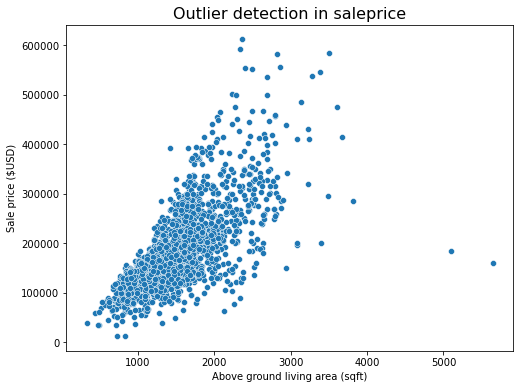

In [10]:
#look at those weirdos out there on the right
plt.figure(figsize=(8,6))
sns.scatterplot(x='gr_liv_area',y='saleprice',data=training);
plt.xlabel('Above ground living area (sqft)')
plt.ylabel('Sale price ($USD)')
plt.title('Outlier detection in saleprice', size=16);

In [11]:
#remove outliers by implementing recommended 4000sqft threshold
training = training[training['gr_liv_area']<4000]

## Merge train and test for synchronized cleaning
Separate saleprice (y_train) so train and test are the same shape.

In [12]:
#add identifier
training['is_train'] = 1
testing['is_train'] = 0

In [13]:
training.head(2)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,is_train
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500,1
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000,1


In [14]:
testing.head(2)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,is_train
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD,0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,0


In [15]:
#merge all but saleprice
allofit = pd.concat((training.drop(columns='saleprice'), testing))

In [16]:
#allofit.head()

### False Nulls
According to the data dictionary, 'NA' can be used to indicate that a particular property attribute does not exist, amidst an otherwise ordinal list of ranking that attribute.  For instance, 'Rating of basement finished area' is on a scale of Unfinished up to Good Living Quarters, with NA indicating that there is no basement.  In this scenario, NA can = 0, Unfinished = 1, and Good Living Quarters = max.

NA is defined as its own level of ordinal rank (0) in the case of 12 variables.  Many of these share the same 6-level scale (NA, Po, Fa, TA, Gd, Ex).  They also share this scale with other ordinal variables in the dataset that do not contain (or define) NA.  I will convert all of these to a numeric scale together, with Na=0 to Ex=5.  

The Pool variable has all of these levels except for 'Po'; I will still include it in this same scale and just record 0 entries at (Po:1).  Apparently in Ames, any pool is already considered 'Fair', but as a water sport athlete I can tell you there are DEFINITELY 'Poor' pools and Ames county is ignoring a valuable metric.

---
### Not so false nulls


Other vars in the data dictionary were NOT stipulated to have meaningful NaNs.  I initially ran them through the same function to convert since there WERE no nulls, so it didn't matter that they were getting replaced with 0.  However, if the TEST data has nulls there, then I'm potentially messing with distribution.  For these vars (lot shape, utilities, land slope, electrical, functional), replace (hypothetical) nulls with the median of the training data.

In [17]:
#cols needing transform from (ordinal) object to numeric
nans_to_zeros = ['bsmt_qual','bsmt_cond', 'fireplace_qu','garage_qual', 'garage_cond',
                 'kitchen_qual', 'exter_qual','exter_cond','heating_qc','garage_finish', 
                 'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'pool_qc', 'fence']

nans_to_median = ['lot_shape','utilities','land_slope', 'electrical','functional']

In [18]:
to_num_masterdict={'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, #nans_to_zeros cols.
'Unf':1, 'RFn':2, 'Fin':3, #garage_finish
'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4, #fence
'No':1, 'Mn':2, 'Av':3, 'Gd':4,#bsmt_exposure
'Unf':1, 'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6, #bsmtfin_type_1 and 2
'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4, #lot_shape
'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4, #utilities
'Sev':1, 'Mod':2, 'Gtl':3, #land_slope
'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7, #functional
'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5} #electrical

In [19]:
#conversion function
def to_nums_fillna0(df, targetcols):
    for i in targetcols:
        df[i] = df[i].map(to_num_masterdict)
        df[i] = df[i].fillna(0) #no need inplace=T because assigning with =
        #print(df[targetcols].value_counts()) #this line to check work, from source1

In [20]:
to_nums_fillna0(allofit, nans_to_zeros)

In [21]:
allofit.loc[allofit['is_train']==1]['lot_frontage'].median()

68.0

In [22]:
def to_nums_fillna_median(df, targetcols):
    for i in targetcols:
        df[i] = df[i].map(to_num_masterdict)
        df[i] = df[i].fillna(allofit.loc[allofit['is_train']==1][i].median())

In [23]:
to_nums_fillna_median(allofit, nans_to_median)

In [36]:
#allofit[nans_to_zeros].dtypes  #check now numeric - yes

In [35]:
#allofit[nans_to_median].dtypes  #check now numeric - yes
#allofit[nans_to_median].isnull().sum() #no NaNs

lot_shape     0
utilities     0
land_slope    0
electrical    0
functional    0
dtype: int64

In [34]:
#allofit.loc[allofit['is_train']==1].isnull().sum().sort_values(ascending=False).head(17)

## Nominal variables
Nominal variables with a NA definition, according to the data dictionary, are:  
- Alley (Grvl, Pave, NA)
- Garage Type (2Types, Attchd, Basment, BuiltIn, CarPort, Detchd, NA)
- Misc Feature (Elev, Gar2, Othr, Shed, TenC, NA)
- Masonry Veneer Type - not defined as such, but NaNs assumed to be 'no veneer', esp since they all correspond with NaNs for veneer square feet (training data only)
---
#### Remember:
Alley and Misc Feature initially had over 92% null values (training data only).  They are in consideration for dropping altogether.  For now, clean.

In [27]:
def nans2none_nominal(df, targetcols):
    for i in targetcols:
        df[i] = df[i].fillna('None')
        
nominal_nans = ['alley','misc_feature','garage_type','mas_vnr_type']
nans2none_nominal(allofit, nominal_nans)

In [33]:
#allofit.loc[allofit['is_train']==1].isnull().sum().sort_values(ascending=False).head(17)

## Remaining nulls:
* Lot Frontage: is continuous linear feet of street connected to property.  Fillna's with median.

* Garage Yr Built: could fill nas with year of property build or remodel, but no novel information there.  There are six other variables about garages that will conserve the important features (existence, sqft, finish).  Drop Garage yr built; that info will be conserved and it's likely just causing collinearity.

* Mas Vnr Area: all corresponded with NaN for veneer type, so assumed no veneer.  Fill with 0s.

* Like Masonry Veneer, the single digit basement and garage nulls all occur in listings that have no basement or garage, respectively.  Replace with 0s.

In [29]:
allofit['lot_frontage'] = allofit['lot_frontage'].fillna(allofit.loc[allofit['is_train']==1]['lot_frontage'].median())

In [30]:
allofit.drop(columns='garage_yr_blt', inplace=True)

In [31]:
continuous_fill_0 = ['mas_vnr_area','bsmt_half_bath','bsmt_full_bath','bsmtfin_sf_1',
                         'bsmtfin_sf_2','total_bsmt_sf','bsmt_unf_sf','garage_cars','garage_area']

allofit[continuous_fill_0] = allofit[continuous_fill_0].fillna(0)

In [38]:
#source 2
nulls= allofit.isnull().sum().sort_values(ascending=False)
perc= (allofit.isnull().sum()/allofit.isnull().count()).sort_values(ascending=False)
missing_data= pd.concat([nulls, perc],axis=1, keys=['# nulls', '% null'])
missing_data.head()

,# nulls,% null
is_train,0,0.0
sale_type,0,0.0
year_remod/add,0,0.0
roof_style,0,0.0
roof_matl,0,0.0


## Identify binary categories and reformat as numeric
* 'Central air' just has Y and N entries.  Change to 1,0 (essentially same as dummifying + drop_first).  
* 'Paved drive' has Yes, No, and Partial entries.  To binarize, will include Partial into Yes.  
* 'Masonry veneer type' is awfully specific.  Let's reduce to has (1) or has not (0) veneer.

In [39]:
allofit['central_air'] = allofit['central_air'].map({'Y':1, 'N':0})
allofit['paved_drive'] = allofit['paved_drive'].map({'Y':1, 'P':1, 'N':0})
allofit['mas_vnr_type'] = allofit['mas_vnr_type'].map({'BrkFace':1, 'Stone':1, 'BrkCmn':1,
                                                'CBlock':1, 'None':0})

## Stretch ordinal scales
Idea from Gwen: take the numerical variables that represent discrete scales and square the values, forcing the regression to reward higher scores more than a stepwise 0-5 scale.

* Variables in this list include anything transformed in the above category-to-numeric functions, + Overall Quality, and Overall Condition

In [ ]:
#numeric vars on discrete scales
discretios = ['bsmt_qual', 'bsmt_cond', 'bsmt']
#nans_to_zeros = ['bsmt_qual','bsmt_cond', 'fireplace_qu','garage_qual', 'garage_cond',
                 'kitchen_qual', 'exter_qual','exter_cond','heating_qc','garage_finish', 
                 'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'pool_qc', 'fence']

nans_to_median = ['lot_shape','utilities','land_slope', 'electrical','functional']